In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [2]:
d_avg = 2.3e-2   # Середній діаметр, м
l = 23.7e-2   # Довжина стрижня, м
wavelength = 4e-2   # Довжина хвилі, м
h = 15e-2   # Відстань між стрижнями для ДСА, м
N = 2  # кількість стрижнів
ksi = 1 + wavelength / (2 * l) # оптимальний коефіцієнт уповільнення

Побудова ДС одностержневої антени


In [3]:
def calculate_F_sigma(ksi, l, wavelength, theta):
    
    """Обчислення нормованої діаграми спрямованості F_sigma(θ)"""
    mn1 = np.abs((ksi - 1) / (np.sin((np.pi * l / wavelength) * (ksi - 1))))
    mn2 = np.abs((np.sin((np.pi * l / wavelength) * (ksi - np.cos(theta)))) / (ksi - np.cos(theta)))

    return mn1 * mn2

def find_MLW(F, theta):
    
    """Знаходження ширини головної пелюстки на рівні 0.707 за допомогою інтерполяції."""
    interp_F = interp1d(F, theta, kind='linear', bounds_error=False, fill_value='extrapolate')
    return np.round(np.degrees(interp_F(0.707)), 2)

def find_cos_theta(theta):
    
    """Знаходження косинусів тета"""
    var = np.cos(theta)
    return var

def find_peaks_and_troughs_scipy(F, theta):
    
    """Знаходження локальних максимумів та мінімумів функції F за допомогою scipy.signal.find_peaks"""
    # Знаходимо піки (максимуми)
    peaks, _ = find_peaks(F)
    peaks_x = np.round(np.degrees(theta[peaks]), 2)
    peaks_y = F[peaks]

    # Знаходимо мінімуми (інвертуємо функцію і шукаємо піки)
    troughs, _ = find_peaks(-F)
    troughs_x = np.round(np.degrees(theta[troughs]), 2)
    troughs_y = F[troughs]

    return peaks_x, peaks_y, troughs_x, troughs_y

def calculate_FE(ksi, l, wavelength, theta):
    
    """Знаходження ДС у площині Е"""
    F_sigma = calculate_F_sigma(ksi, l, wavelength, theta)
    cos_theta = find_cos_theta(theta)
    return F_sigma * cos_theta

In [4]:
theta = np.arange(0.01, np.pi / 2, 0.001)  # Створюємо масив кутів тета
steps = np.degrees(theta)

F_sigma = calculate_F_sigma(ksi, l, wavelength, theta)
cos_theta = find_cos_theta(theta)
FE = calculate_FE(ksi, l, wavelength, theta)

peaks_x_FH, peaks_y_FH, troughs_x_FH, troughs_y_FH = find_peaks_and_troughs_scipy(F_sigma, theta)
peaks_x_FE, peaks_y_FE, troughs_x_FE, troughs_y_FE = find_peaks_and_troughs_scipy(FE, theta)

MLW_F_sigma = find_MLW(F_sigma, theta)
MLW_FE = find_MLW(FE, theta)

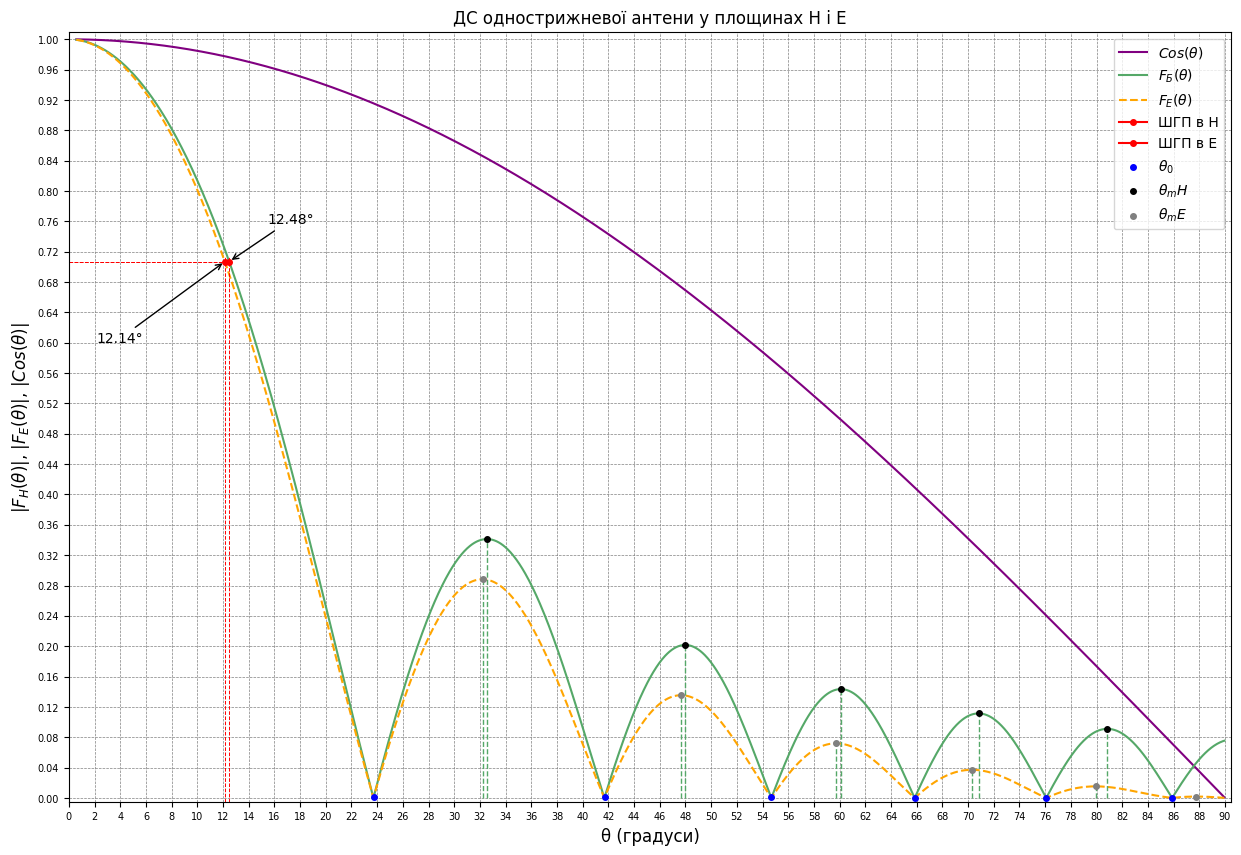

In [5]:
# Візуалізація
plt.figure(figsize=(15, 10))

# Основні графіки
plt.plot(steps, cos_theta, color="purple", linestyle='-', linewidth=1.5, label="$Cos({\\theta})$")
plt.plot(steps, F_sigma, color="#55A868", linestyle='-', linewidth=1.5, label="$F_{Б}(\\theta)$")
plt.plot(steps, FE, color = 'orange', linestyle="dashed", linewidth=1.5, label="$F_{E}(\\theta)$")

# Позначаємо знайдені точки для ШГП
plt.plot(MLW_F_sigma, 0.707, marker="o", color='red', markersize = 4, label="ШГП в H")
plt.plot(MLW_FE, 0.707, marker="o", color='red', markersize = 4, label="ШГП в Е")

# Додаємо вертикальні та горизонтальні лінії для ШГП
plt.axhline(y=0.707, xmin=0, xmax=MLW_F_sigma/90, color="red", linestyle="dashed", linewidth=0.7)
plt.axvline(x=MLW_F_sigma, ymin=0, ymax=0.707, color="red", linestyle="dashed", linewidth=0.7)

plt.axhline(y=0.707, xmin=0, xmax=MLW_FE/90, color="red", linestyle="dashed", linewidth=0.7)
plt.axvline(x=MLW_FE, ymin=0, ymax=0.707, color="red", linestyle="dashed", linewidth=0.7)

# Позначаємо екстремуми
plt.scatter(troughs_x_FH, troughs_y_FH, color="blue", s=16, label="$\\theta_{0}$", zorder=3)
plt.scatter(peaks_x_FH, peaks_y_FH, color="black", s=16, label="$\\theta_{m}H$", zorder=3)
plt.scatter(peaks_x_FE, peaks_y_FE, color="grey", s=16, label="$\\theta_{m}E$", zorder=3)

# Додаємо перпендикулярні лінії з максимумів до осі Ox
for x, y in zip(peaks_x_FH, peaks_y_FH):
    plt.vlines(x=x, ymin=0, ymax=y, colors='#55A868', linestyle='--', linewidth=1)

for x, y in zip(peaks_x_FE, peaks_y_FE):
    plt.vlines(x=x, ymin=0, ymax=y, colors='#55A868', linestyle='--', linewidth=1)

# Додаємо анотацію для ШГП
plt.annotate(f'{MLW_F_sigma:.2f}\u00b0',
             xy=(MLW_F_sigma, 0.707),
             xytext=((MLW_F_sigma) + 3, 0.757),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

plt.annotate(f'{MLW_FE:.2f}\u00b0',
             xy=(MLW_FE, 0.707),
             xytext=((MLW_FE) - 10, 0.6),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

# Форматування графіку
plt.xlabel("θ (градуси)", fontsize=12)
plt.ylabel("$|F_H(\\theta)|$, $|F_E(\\theta)|$, $|Cos({\\theta})|$", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.title("ДС однострижневої антени у площинах H і E", fontsize=12)

# Налаштування візуалізації осей
plt.xticks(np.arange(0, 100, 2), fontsize=7)
plt.yticks(np.arange(0, 1.2, 0.04), fontsize=7)
plt.ylim(-0.005, 1.01)
plt.xlim(0, 90.5)

plt.show()

Побудова ДС двостержневої антени


In [6]:
def calculate_FH_double_rod(ksi, l, wavelength, theta, h):
    """Обчислення ДС двострижневої антени у площині Н"""
    F_sigma = calculate_F_sigma(ksi, l, wavelength, theta)
    FH = np.abs(F_sigma * np.cos((np.pi * h / wavelength) * np.sin(theta)))
    return FH

In [7]:
def calculate_FC(theta, h, wavelength):
    """Обчислення множника грат"""
    return np.abs(np.cos((np.pi * h / wavelength) * np.sin(theta)))

In [8]:
def calculate_FE_double_rod(ksi, l, wavelength, theta, h):
    """Обчислення ДС двострижневої антени у площині Е"""
    FH = calculate_FH_double_rod(ksi, l, wavelength, theta, h)
    cos_theta = find_cos_theta(theta)
    return FH * cos_theta

In [9]:
FC = calculate_FC(theta, h, wavelength)
FE = calculate_FE_double_rod(ksi, l, wavelength, theta, h)
FH = calculate_FH_double_rod(ksi, l, wavelength, theta, h)

MLW_FE = find_MLW(FE, theta)
MLW_FH  = find_MLW(FH, theta)

peaks_x_FH, peaks_y_FH, troughs_x_FH, troughs_y_FH = find_peaks_and_troughs_scipy(FH, theta)
peaks_x_FE, peaks_y_FE, troughs_x_FE, troughs_y_FE = find_peaks_and_troughs_scipy(FE, theta)

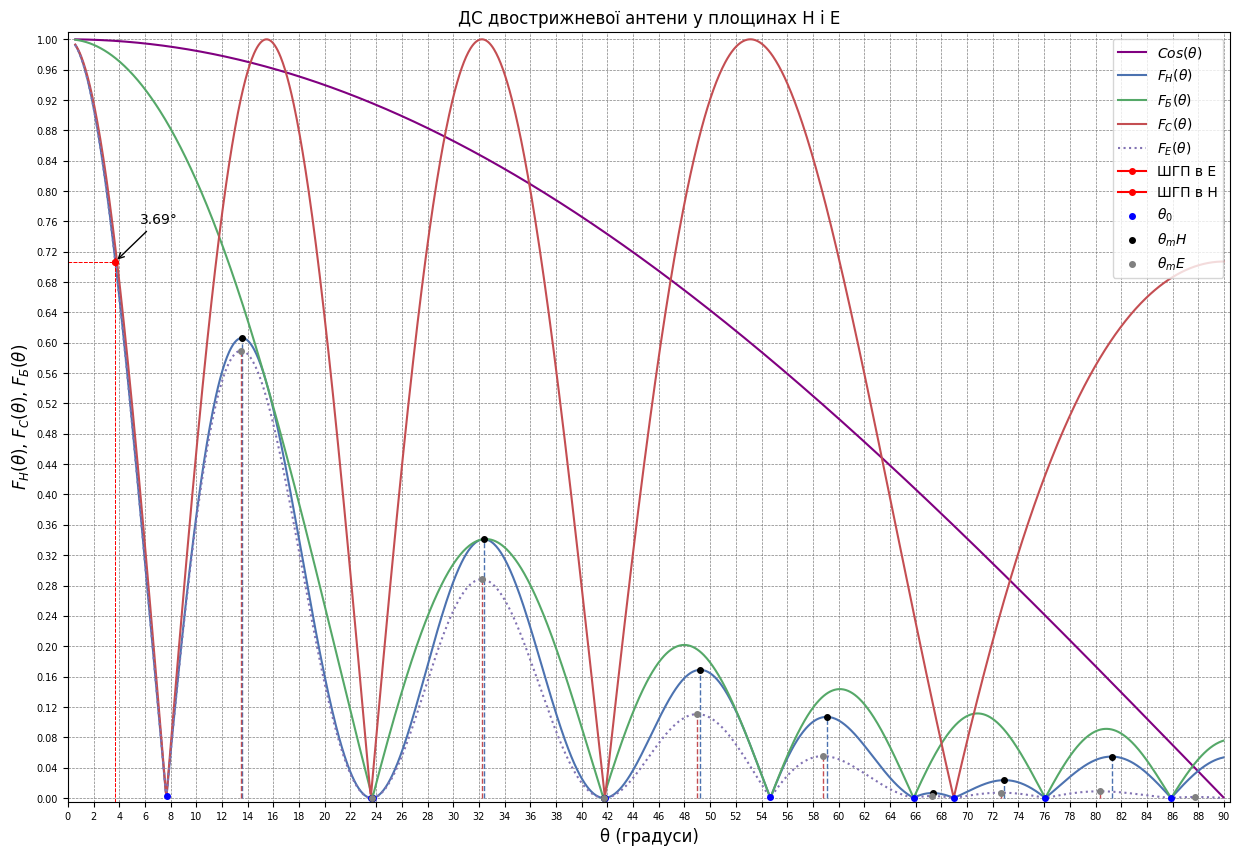

In [10]:
# Візуалізація
plt.figure(figsize=(15, 10))

# Основні графіки
plt.plot(steps, cos_theta, color="purple", linestyle='-', linewidth=1.5, label="$Cos({\\theta})$")
plt.plot(steps, FH, linestyle='-', color="#4C72B0", linewidth=1.5, label="$F_{H}(\\theta)$")
plt.plot(steps, F_sigma, color="#55A868", linestyle='-', linewidth=1.5, label="$F_{Б}(\\theta)$")
plt.plot(steps, FC, color="#C44E52", linestyle='-', linewidth=1.5, label="$F_{C}(\\theta)$")
plt.plot(steps, FE, color="#8172B3", linestyle=':', linewidth=1.5, label="$F_{E}(\\theta)$")

# Позначаємо знайдені точки для ШГП
plt.plot(MLW_FE, 0.707, marker="o", color='red', markersize=4, label="ШГП в Е")
plt.plot(MLW_FH, 0.707, marker="o", color='red', markersize=4, label="ШГП в Н")

# Додаємо вертикальні та горизонтальні лінії для ШГП
plt.axhline(y=0.707, xmin=0, xmax=MLW_FE/90, color="red", linestyle="dashed", linewidth=0.7)
plt.axvline(x=MLW_FE, ymin=0, ymax=0.707, color="red", linestyle="dashed", linewidth=0.7)

plt.axhline(y=0.707, xmin=0, xmax=MLW_FH/90, color="red", linestyle="dashed", linewidth=0.7)
plt.axvline(x=MLW_FH, ymin=0, ymax=0.707, color="red", linestyle="dashed", linewidth=0.7)

# Позначаємо екстремуми
plt.scatter(troughs_x_FH, troughs_y_FH, color="blue", s=16, label="$\\theta_{0}$", zorder=3)
plt.scatter(peaks_x_FH, peaks_y_FH, color="black", s=16, label="$\\theta_{m}H$", zorder=3)
plt.scatter(peaks_x_FE, peaks_y_FE, color="grey", s=16, label="$\\theta_{m}E$", zorder=3)

# Перпендикуляри до максимумів
for x, y in zip(peaks_x_FH, peaks_y_FH):
    plt.vlines(x=x, ymin=0, ymax=y, colors='#4C72B0', linestyle='--', linewidth=1)

for x, y in zip(peaks_x_FE, peaks_y_FE):
    plt.vlines(x=x, ymin=0, ymax=y, colors='#C44E52', linestyle='--', linewidth=1)

# Анотація для ШГП
plt.annotate(f'{MLW_FE:.2f}\u00b0',
             xy=(MLW_FE, 0.707),
             xytext=(MLW_FE + 1.9, 0.757),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

# Форматування графіку
plt.xlabel("θ (градуси)", fontsize=12)
plt.ylabel("$F_H(\\theta)$, $F_C(\\theta)$, $F_Б(\\theta)$", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray')
plt.title("ДС двострижневої антени у площинах H і E", fontsize=12)

# Налаштування візуалізації осей
plt.xticks(np.arange(0, 100, 2), fontsize=7)
plt.yticks(np.arange(0, 1.2, 0.04), fontsize=7)
plt.ylim(-0.005, 1.01)
plt.xlim(0, 90.5)

plt.show()